In [1]:
#import das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#lendo a planilha e transformando em um DataFrame
dataframe = pd.read_csv('brazil_municipalities_population.csv')

In [3]:
#Verificação de quantidade de linha e quantidade de colunas
dataframe.shape

(145380, 6)

In [4]:
#Verificando o nome das colunas existentes
dataframe.columns

Index(['year', 'id_municipality', 'name_municipality', 'abbrev_state',
       'population', 'source'],
      dtype='object')

In [5]:
#Exibindo as 5 primeiras linhas do DataFrame
dataframe.head()

,year,id_municipality,name_municipality,abbrev_state,population,source
0,1970,1100106,Guajará-Mirim,RO,27016,Census
1,1970,1100205,Porto Velho,RO,84048,Census
2,1970,1200104,Brasiléia,AC,12311,Census
3,1970,1200203,Cruzeiro do Sul,AC,43584,Census
4,1970,1200302,Feijó,AC,15768,Census


In [6]:
#Contato a quantidade de nan por coluna
dataframe.isna().sum()

year                 0
id_municipality      0
name_municipality    0
abbrev_state         0
population           0
source               0
dtype: int64

In [7]:
#formatanto quantas casas decimais irá mostrar
pd.set_option('display.float_format', '{:.2f}'.format)
#Descrição da coluna população
dataframe['population'].describe()

count     145380.00
mean       34201.76
std       202157.69
min          732.00
25%         5371.00
50%        11194.00
75%        23668.00
max     12396372.00
Name: population, dtype: float64

In [8]:
media_populacao = dataframe['population'].mean()
print(f'Média da populção de 1970 - 2021: {media_populacao:.0f}')

Média da populção de 1970 - 2021: 34202


In [9]:
#total de estados
quantidade_estado = len(dataframe['abbrev_state'].unique())
print(f'O Brasil tem {quantidade_estado} estados')

O Brasil tem 27 estados


In [51]:
#Quantidade de cidade por estado e quantidade de cidade total no Brasil
quantidade_de_cidade_estado = dataframe.groupby('abbrev_state')['name_municipality'].nunique().reset_index().sort_values(by='name_municipality', ascending=False)
quantidade_de_cidade_estado.columns = ['Estado', 'Quantidade de cidade']
quantidade_total_brasil = quantidade_de_cidade_estado['Quantidade de cidade'].sum()
print(f'O Brasil tem {quantidade_total_brasil} cidades')
for i in range(len(quantidade_de_cidade_estado)):
    print(f'O estado {quantidade_de_cidade_estado.iloc[i]["Estado"]} tem {quantidade_de_cidade_estado.iloc[i]["Quantidade de cidade"]} cidades')

O Brasil tem 5570 cidades
O estado MG tem 853 cidades
O estado SP tem 645 cidades
O estado RS tem 497 cidades
O estado BA tem 417 cidades
O estado PR tem 399 cidades
O estado SC tem 295 cidades
O estado GO tem 246 cidades
O estado PI tem 224 cidades
O estado PB tem 223 cidades
O estado MA tem 217 cidades
O estado PE tem 185 cidades
O estado CE tem 184 cidades
O estado RN tem 167 cidades
O estado PA tem 144 cidades
O estado MT tem 141 cidades
O estado TO tem 139 cidades
O estado AL tem 102 cidades
O estado RJ tem 92 cidades
O estado MS tem 79 cidades
O estado ES tem 78 cidades
O estado SE tem 75 cidades
O estado AM tem 62 cidades
O estado RO tem 52 cidades
O estado AC tem 22 cidades
O estado AP tem 16 cidades
O estado RR tem 15 cidades
O estado DF tem 1 cidades


In [12]:
#Quantidade da populão alinhada por estado e ano
df_populacao_estado_ano = dataframe.groupby(['year', 'abbrev_state'])['population'].sum().reset_index().sort_values(by=['year', 'population'], ascending=[True, False])
df_populacao_estado_ano



,year,abbrev_state,population
25,1970,SP,17770975
10,1970,MG,11485663
18,1970,RJ,8994802
4,1970,BA,7493437
17,1970,PR,6929821
...,...,...,...
722,2022,RO,1581196
728,2022,TO,1511460
702,2022,AC,830018
705,2022,AP,733759


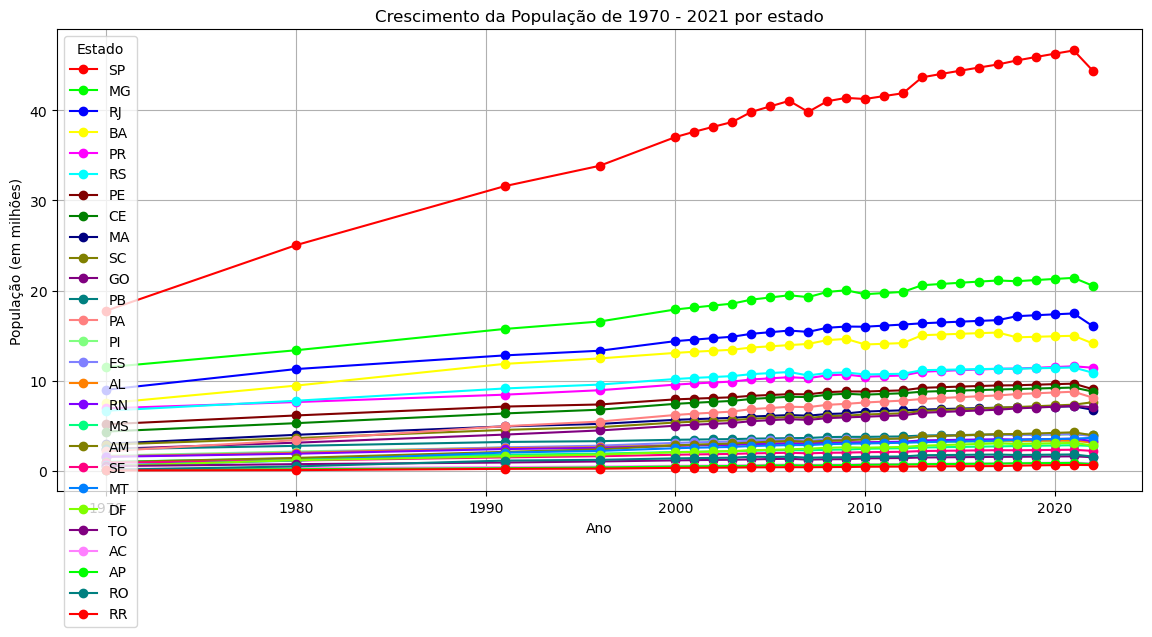

In [13]:
# Lista de cores em hexadecimal (27 cores)
colors = [
    '#FF0000',  # Vermelho
    '#00FF00',  # Verde
    '#0000FF',  # Azul
    '#FFFF00',  # Amarelo
    '#FF00FF',  # Magenta
    '#00FFFF',  # Ciano
    '#800000',  # Marrom
    '#008000',  # Verde escuro
    '#000080',  # Azul marinho
    '#808000',  # Verde oliva
    '#800080',  # Roxo
    '#008080',  # Verde-água
    '#FF8080',  # Rosa claro
    '#80FF80',  # Verde claro
    '#8080FF',  # Azul claro
    '#FF8000',  # Laranja
    '#8000FF',  # Roxo forte
    '#00FF80',  # Verde menta
    '#808000',  # Mostarda
    '#FF0080',  # Rosa choque
    '#0080FF',  # Azul celeste
    '#80FF00',  # Limão
    '#800080',  # Púrpura
    '#FF80FF',  # Rosa claro
    '#00FF00',  # Verde fluorescente
    '#008080',  # Azul petróleo
    '#FF0000'   # Vermelho forte
]

# Criando um dicionário para mapear cada estado a uma cor específica
estado_para_cor = {estado: colors[i % len(colors)] for i, estado in enumerate(df_populacao_estado_ano['abbrev_state'].unique())}

# Configurando o tamanho do gráfico
plt.figure(figsize=(14, 6))

# Plotando o gráfico de linhas para cada estado com cores diferentes
for estado in df_populacao_estado_ano['abbrev_state'].unique():
    df_estado = df_populacao_estado_ano[df_populacao_estado_ano['abbrev_state'] == estado]
    plt.plot(df_estado['year'], df_estado['population'] / 1e6, marker='o', label=estado, color=estado_para_cor[estado])  # Usando a cor do estado

# Customizações do gráfico
plt.title('Crescimento da População de 1970 - 2021 por estado')
plt.xlabel('Ano')
plt.ylabel('População (em milhões)')
plt.legend(title='Estado')
plt.grid(True)

# Exibindo o gráfico
plt.show()